<a href="https://colab.research.google.com/github/rahiakela/deep-learning-research-and-practice/blob/main/inside-deep-learing/11-seq-2-seq/01_sequence_to_sequence.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Sequence-tosequence

In particular, we will develop an algorithm known as sequence-tosequence
(Seq2Seq for short) that can perform machine translation. As the name implies,
this is an approach for getting neural networks to take one sequence as input and
produce a different sequence as the output. 

Seq2Seq has been used to get computers to
perform symbolic calculus, summarize long documents, and even translate from one
language to another. I’ll show you step by step how we can translate from English to
French.

You
could hypothetically get an RNN to do anything Seq2Seq could do, but it would be
difficult to get it to work. One problem is that an RNN alone implies that the output
sequence is the same length as the input, which is rarely true. Seq2Seq decouples the
input and output into two separate stages and parts and thus works much better.

At a high level, the Seq2Seq algorithm trains a
denoising autoencoder over sequences rather than static images. 

You can think of the
original English as the noisy input and French as the clean output, and we ask the
Seq2Seq model to learn how to remove the noise.

We have an
encoder and decoder to convert inputs to outputs just like a denoising autoencoder;
the difference is that a Seq2Seq model works over sequences instead of images or fully
connected inputs.

![](https://github.com/rahiakela/deep-learning-research-and-practice/blob/main/inside-deep-learing/11-seq-2-seq/images/seq2seq.png?raw=1)

Here we have some original input sequence $X = x_1, x_2, ..., x_T$ , and the goal is to
output a new sequence $Y = y_1, y_2, ..., y_{\hat T}$ . These sequences do not have to be the
same. $x_j \neq y_j$ , and they can even be different lengths so T $6 \neq \hat T$ is also possible.

The secret to getting a Seq2Seq model working well is adding an attention mechanism.

![](https://github.com/rahiakela/deep-learning-research-and-practice/blob/main/inside-deep-learing/11-seq-2-seq/images/seq2seq_attn.png?raw=1)

Notice that the last
hidden state from the encoder, hT , becomes the initial hidden state of the decoder, but
we haven’t indicted what the inputs to the decoder are at each time step.

##Setup

In [ ]:
!wget https://github.com/EdwardRaff/Inside-Deep-Learning/raw/main/idlmam.py

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision 
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
from torchvision import transforms

from torch.utils.data import Dataset, DataLoader

from tqdm.autonotebook import tqdm

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow

import pandas as pd

from sklearn.metrics import accuracy_score

import time
from io import BytesIO
from zipfile import ZipFile
from urllib.request import urlopen
import re

from idlmam import train_network, Flatten, weight_reset, View, set_seed
from idlmam import AttentionAvg, GeneralScore, DotScore, AdditiveAttentionScore, ApplyAttention, getMaskByFill

In [3]:
%matplotlib inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('png', 'pdf')

from IPython.display import display_pdf
from IPython.display import Latex

<ipython-input-3-024163930d81>:3: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('png', 'pdf')


In [4]:
torch.backends.cudnn.deterministic=True
set_seed(42)

In [5]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

##English-French dataset

In [6]:
# let’s quickly load small English-French dataset
all_data = []
response = urlopen("https://download.pytorch.org/tutorial/data.zip")
zipfile = ZipFile(BytesIO(response.read()))

for line in zipfile.open("data/eng-fra.txt").readlines():
  line = line.decode("utf-8").lower()   # lower case only please
  line = re.sub(r"[-.!?]+", r" ", line) # no puntuation
  source_lang, target_lang = line.split("\t")[0: 2]
  all_data.append((source_lang.strip(), target_lang.strip())) # (english, french)

In [7]:
for i in range(10):
  print(all_data[i])

('go', 'va')
('run', 'cours')
('run', 'courez')
('wow', 'ça alors')
('fire', 'au feu')
('help', "à l'aide")
('jump', 'saute')
('stop', 'ça suffit')
('stop', 'stop')
('stop', 'arrête toi')


In [8]:
all_data[:10]

[('go', 'va'),
 ('run', 'cours'),
 ('run', 'courez'),
 ('wow', 'ça alors'),
 ('fire', 'au feu'),
 ('help', "à l'aide"),
 ('jump', 'saute'),
 ('stop', 'ça suffit'),
 ('stop', 'stop'),
 ('stop', 'arrête toi')]

In [9]:
# To make training faster, let’s limit ourselves to sentences that contain six or fewer words.
short_subset = []
MAX_LEN = 6

for (s, t) in all_data:
  if max(len(s.split(" ")), len(t.split(" "))) <= MAX_LEN:
    short_subset.append((s, t))
print(f"Using {len(short_subset)} / {len(all_data)}")

Using 66251 / 135842


In [10]:
# let's defines SOS, EOS, and padding markers and creates a dictionary word2indx to create the mapping 
# and an inverted dictionary indx2word so that we can look at our results more easily when we are done
SOS_token = "<SOS>"  # START_OF_SENTANCE_TOKEN
EOS_token = "<EOS>"  # END_OF_SENTANCE_TOKEN
PAD_token = "_PADDING_"

word2index = {PAD_token: 0, SOS_token: 1, EOS_token: 2}
for s, t in short_subset:
  for sentance in (s, t):
    for word in sentance.split(" "):
      if word not in word2index:
        word2index[word] = len(word2index)
print(f"Size of Vocab: {len(word2index)}")

# build the inverted dict for looking at the outputs later
index2word = {}
for word, index in word2index.items():
  index2word[index] = word

Size of Vocab: 24577


In [11]:
class TranslationDataset(Dataset):
  """
  Takes a dataset with tuples of strings (x, y) and converts them to tuples of int64 tensors. 
  This makes it easy to encode Seq2Seq problems.
  
  Strings in the input and output targets will be broken up by spaces
  """
  def __init__(self, lang_pairs, word2index):
    """
    lang_pairs: a List[Tuple[String,String]] containing the source,target pairs for a Seq2Seq problem. 
    word2indx: a Map[String,Int] that converts each word in an input string into a unique ID.
    """
    self.lang_pairs = lang_pairs 
    self.word2index = word2index 

  def __len__(self):
    return len(self.lang_pairs)

  def __getitem__(self, idx):
    x, y = self.lang_pairs[idx]
    x = SOS_token + " " + x + " " + EOS_token
    y = y + " " + EOS_token
    
    # convert to lists of integers
    x = [self.word2index[w] for w in x.split(" ")]
    y = [self.word2index[w] for w in y.split(" ")]

    x = torch.tensor(x, dtype=torch.int64)
    y = torch.tensor(y, dtype=torch.int64)

    return x, y

In [12]:
big_dataset = TranslationDataset(short_subset, word2index)

In [13]:
# let's define a collate_fn function to create one larger batch from the inputs that are different lengths
def pad_batch(batch):
  """Pad items in the batch to the length of the longest item in the batch"""
  """
  We actually have two different maxiumum lengths! 
  The max length of the input sequences, and the max length of the output sequences. 
  So we will determine each seperatly, and only pad the inputs/outputs by the exact amount we need
  """
  max_x = max([i[0].size(0) for i in batch])
  max_y = max([i[1].size(0) for i in batch])

  PAD = word2index[PAD_token]

  # We will use the F.pad function to pad each tensor to the right
  X = [F.pad(i[0], (0, max_x[0].size(0)), value=PAD) for i in batch]
  Y = [F.pad(i[1], (0, max_y[1].size(0)), value=PAD) for i in batch]

  X, Y = torch.stack(X), torch.stack(Y)
  return (X, Y), Y

In [14]:
# Want a consistent dataset split
set_seed(42)

B = 128
epochs = 10

train_size = round(len(big_dataset) * 0.9)
test_size = len(big_dataset) - train_size

train_dataset, test_dataset = torch.utils.data.random_split(big_dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=B, shuffle=True, collate_fn=pad_batch)
test_loader = DataLoader(test_dataset, batch_size=B, collate_fn=pad_batch)

##Inputs to Seq2Seq

The attention mechanism can work with both teacher forcing and the autoregressive `t'th` approach and will change how we make predictions about the current word at the step of the RNN.

So rather than have the decoder RNN predict $\hat y_t$, we have it produce
a latent value $\hat z_t$. The value $\hat z_t$ is our context for the attention mechanism.

1. The encoder step learns a useful representation of the input.
2. The decoder step predicts a context for each item of the output.
3. The attention step uses the context to produce an output $\hat x_t$, which is combined with the context $\hat z_t$.
4. The prediction step takes the combined attention/context result and predicts the next token of the sequence.



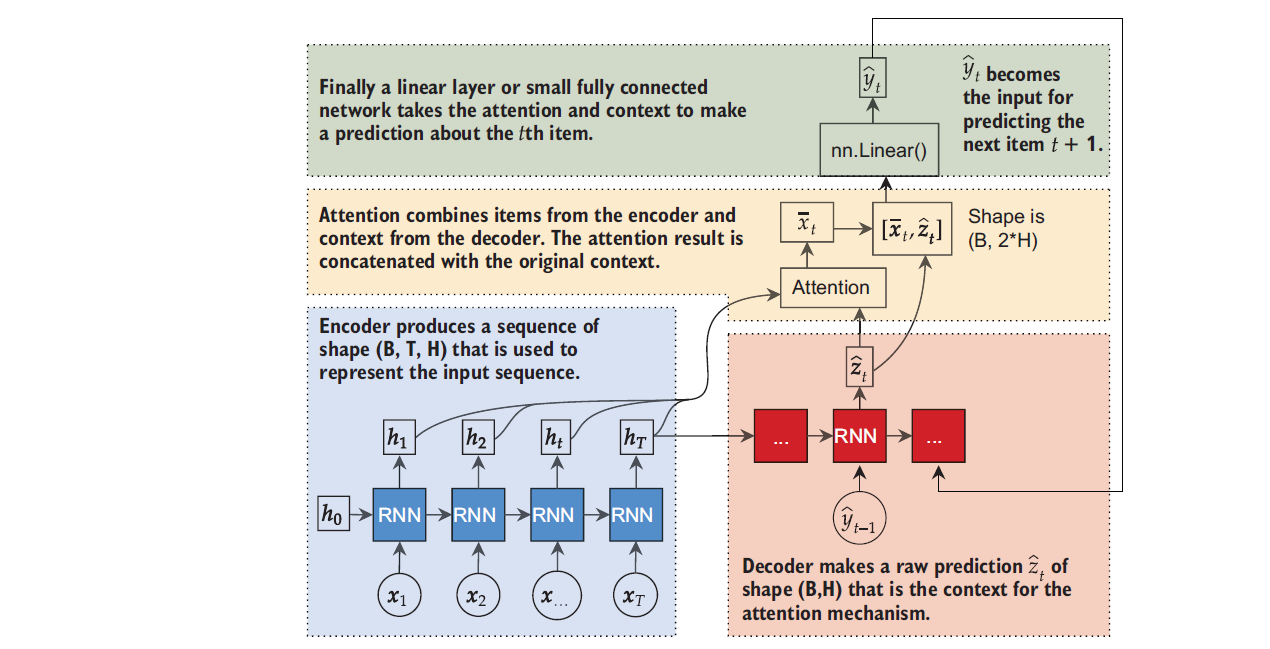

In [15]:
class Seq2SeqAttention(nn.Module):

  def __init__(self, num_embeddings, embedding_size, hidden_size, padding_idx=None, layers=1, max_decode_length=20):
    super(Seq2SeqAttention, self).__init__()

    self.padding_idx = padding_idx 
    self.hidden_size = hidden_size
    self.embedding_layer = nn.Embedding(num_embeddings, embedding_size, padding_idx=padding_idx)

    """
    We set the hidden size to half the intended length, because we will make the encoder bi-directional.
    That means we will get 2 hidden state representations which we will concatinate together, giving us the desired size!
    """
    self.encoding_layers = nn.GRU(input_size=embedding_size, hidden_size=hidden_size // 2, num_layers=layers, bidirectional=True)

    # But decoder will be uni-directionall, and we need to use CRUCells so that we can do the decoding one step at a time
    self.decoding_layers = nn.ModuleList([nn.GRUCell(embedding_size, hidden_size)] + [nn.GRUCell(hidden_size, hidden_size) for i in range(layers - 1)])
    self.score_net = DotScore(hidden_size)

    """
    predict_word will be a small fully connected network that we use to convert the  result of the attention mechanism 
    and the local context into a prediction for the next word
    """
    self.predict_word = nn.Sequential(
      nn.Linear(2 * hidden_size, hidden_size),
      nn.LeakyReLU(),
      nn.LayerNorm(hidden_size),

      nn.Linear(hidden_size, hidden_size),
      nn.LeakyReLU(),
      nn.LayerNorm(hidden_size),

      nn.Linear(hidden_size, num_embeddings)
    )

    self.max_decoding_length = max_decode_length
    self.apply_attention = ApplyAttention()

  def forward(self, input):
    ###################################################
    # Step-1 : Preparation, embedding, and masking block
    ###################################################
    # Input should be (B, T) or ((B, T), (B, T')) depending on whether we are in testing or training mode
    if isinstance(input, tuple):
      input, target = input
    else:
      target = None

    # What is the batch size?
    B = input.size(0)
    # What is the max number of input time steps?
    T = input.size(1)
    # embd all of the input values (B, T, D)
    x = self.embedding_layer(input)

    # grab the device that the model currently resides on we will need this later
    device = x.device 

    # We will use the mask to figure out how long each input sequence is
    mask = getMaskByFill(x)
    seq_lengths = mask.sum(dim=1).view(-1) # shape (B), containing the # of non-zero values

    ###################################################
    #   Step-2 : Encoding block
    ###################################################
    # the sequence lengths will be used to create a packed input for the encoder RNN
    x_packed = pack_padded_sequence(x, seq_lengths.cpu(), batch_first=True, enforce_sorted=False)
    h_encoded, h_last = self.encoding_layers(x_packed)
    h_encoded, _ = pad_packed_sequence(h_encoded)  # (B, T, 2, D//2) , b/c its bidirectional
    # (B, T, D), Now h_encoded is the result of running the encoder RNN on the input!
    h_encoded = h_encoded.view(B, T, -1)

    # Getting the last hidden state is a little trickier
    # first the output gets reshaped as (num_layers, directions, batch_size, hidden_size)
    # and then we grab the last index in the first dimension, because we want the last layer's output
    hidden_size = h_encoded.size(2)
    h_last = h_last.view(-1, 2, B, hidden_size // 2)[-1, :, :, :]  # The shape is now (2, B, D/2)
    # now we will reorder to (B, 2, D/2), and flatten the last two dimensions down to (B, D)
    h_last = h_last.permute(1, 0, 2).reshape(B, -1)
    # End of Encoding portion. 
    # h_encoded now contains the representation of the input data!
    # h_last has the final ouputs of the RNN, to use as the initial input state for the decoder

    ###################################################
    #   Step-3 : Decoding block
    ###################################################
    # The first input to the decoder will be the output of the last encoder step decoder_input = h_last
    




IndentationError: ignored